In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

In [4]:
#data preparation
data = datasets.FashionMNIST(root= "data", train = True,download = True, transform = transforms.ToTensor())

num_train = 40000
num_valid = 10000
num_test = 10000

train_data, valid_data, test_data = random_split(data, [num_train, num_valid, num_test])

train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
valid_dataloader = DataLoader(valid_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

100%|██████████| 26421880/26421880 [00:14<00:00, 1870478.40it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 135907.35it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2550280.62it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5802815.64it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
# MLP Class
class MLP(nn.Module):
    def __init__(self, input, hidden, output, activation_fun, optimizer_method, alpha,device):
        super(MLP, self).__init__()
        #super().__init__()
        self.flatten = nn.Flatten()
        self.device = torch.device(device)
        self.input = input
        self.hidden = hidden
        self.output = output
        self.activation_fun = activation_fun
        self.optimizer_method = optimizer_method
        self.alpha = alpha

        self.layers = nn.ModuleList()
        old_size = input
        for size in hidden:
            self.layers.append(nn.Linear(old_size, size))
            old_size = size
        self.layers.append(nn.Linear(old_size, output))
        if activation_fun == 'relu':
            self.activation = nn.ReLU()
        elif activation_fun == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_fun == 'tanh':
            self.activation = nn.Tanh()
        elif activation_fun == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        else:
            print("Invalid activation function.")

        if self.optimizer_method == 'adam':
            self.optimizer = optim.Adam(self.parameters(), lr = self.alpha)
        elif self.optimizer_method == 'adagrad':
            self.optimizer = optim.Adagrad(self.parameters(), lr = self.alpha)
        elif self.optimizer_method == 'sgd':
            self.optimizer = optim.SGD(self.parameters(), lr = self.alpha)
        else:
            print("Unknown Optimizer Method:" + self.optimizer_method)

        self.dropout = nn.Dropout(0.2)
        self.to(self.device)

    def forward(self,x):
        x = self.flatten(x).to(self.device)
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.layers[-1](x)
        return x

In [6]:
def gpu_device():
    device = ("cuda" if torch.cuda.is_available() else "cpu")
    return device

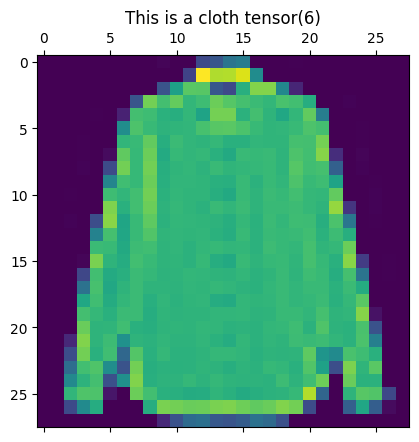

In [7]:
def save_img(img, label, file_name, num_rows = 28, num_cols = 28):
    example = np.reshape(img, (num_rows, num_cols))
    plt.matshow(example)
    plt.title("This is a cloth " + str(label))
    plt.savefig(file_name)

data_iter = iter(train_dataloader)
images, labels = next(data_iter)

save_img(images[0], labels[0], 'example.png')

In [8]:
def training_model(model, train_dataloader, valid_dataloader, num_epochs,device, num_train_iters,num_valid_iters, batch_size):
  best_acc = 0
  model.train()
  Optimizer = model.optimizer
  for state in Optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
  for epoch in range(num_epochs):
      print('Epochs: ' + str(epoch)+' -------------------------')
      avg_loss = 0
      avg_acc = 0
      for i, (x, y) in enumerate(train_dataloader):
          x = x.to(model.device)
          y = y.to(model.device)
          Optimizer.zero_grad()
          predict = model(x)
          loss = nn.CrossEntropyLoss()(predict, y)
          loss.backward()
          Optimizer.step()
          avg_loss += loss.item()
          avg_acc += (predict.argmax(1) == y).sum().item()

  avg_loss = avg_loss / num_train_iters
  avg_acc = avg_acc / (num_train_iters * batch_size)
  print('Training Loss: ' + str(avg_loss))
  print('Training Accuracy: ' + str(avg_acc))

  with torch.no_grad():
    model.eval()
    all_predict = []
    all_labels = []
    for i, (x, y) in enumerate(valid_dataloader):
        x = x.to(model.device)
        y = y.to(model.device)
        predict = model(x)
        all_predict.append(torch.argmax(predict, dim = 1))
        all_labels.append(y)

    all_predict = torch.cat(all_predict, dim = 0)
    all_labels = torch.cat(all_labels, dim = 0)

    acc = ((all_predict == all_labels).sum().item() / len(all_labels))*100
    print('Validation Accuracy: ' + str(acc))
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model.pth')
  model.load_state_dict(torch.load("best_model.pth"))

In [9]:
def evaluate_model(model, test_dataloader, num_epochs, device):
  model.eval()
  all_predict = []
  all_labels = []
  with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        x = x.to(model.device)
        y = y.to(model.device)
        predict = model(x)
        all_predict.append(torch.argmax(predict,dim = 1))
        all_labels.append(y)

    all_predict = torch.cat(all_predict, dim = 0)
    all_labels = torch.cat(all_labels)

    test_acc = ((all_predict == all_labels).sum().item() / len(all_labels))*100
    print('-------------------------------')
    print('Test Accuracy: ' + str(test_acc))
    c = torch.zeros(num_output, num_output)
    for i in range(num_output):
      indices = all_labels == i
      count = torch.sum(indices).item()
      assert count == all_predict[indices].size(0)
      arr = all_predict[indices]
      for j in range(num_output):
          c[i,j] = torch.sum(arr == j).item() * 100/ count
    print("Confusion_Matrix:\n",c)
    plt.clf()
    plt.matshow(c)
    plt.savefig('Confusion_Matrix.png')

    print('Done')


In [10]:
num_input = 28*28
num_hidden = input("Enter the number of neurons in hidden layer, as comma separated values eg. 64,32 or 128,64,32\n")
num_hidden = [int(x) for x in num_hidden.split(',')]
num_output = 10
alpha = 1e-4
num_epochs = 100
batch_size = 64
num_train_iters = len(train_dataloader) // batch_size
num_valid_iters = len(valid_dataloader) // batch_size
num_test_iters = len(test_dataloader) // batch_size

device = gpu_device()
model = MLP(num_input, num_hidden, num_output, 'relu', 'adam', alpha, device)
#model1 = MLP(num_input, num_hidden, num_output, 'relu', 'adagrad', alpha, device)
training_model(model, train_dataloader, valid_dataloader, num_epochs, device,num_train_iters,num_valid_iters,batch_size)
#training_model(model1, train_dataloader, valid_dataloader, num_epochs, device,num_train_iters,num_valid_iters,batch_size)


Enter the number of neurons in hidden layer, as comma separated values eg. 64,32 or 128,64,32
64,32
Epochs: 0 -------------------------
Epochs: 1 -------------------------
Epochs: 2 -------------------------
Epochs: 3 -------------------------
Epochs: 4 -------------------------
Epochs: 5 -------------------------
Epochs: 6 -------------------------
Epochs: 7 -------------------------
Epochs: 8 -------------------------
Epochs: 9 -------------------------
Epochs: 10 -------------------------
Epochs: 11 -------------------------
Epochs: 12 -------------------------
Epochs: 13 -------------------------
Epochs: 14 -------------------------
Epochs: 15 -------------------------
Epochs: 16 -------------------------
Epochs: 17 -------------------------
Epochs: 18 -------------------------
Epochs: 19 -------------------------
Epochs: 20 -------------------------
Epochs: 21 -------------------------
Epochs: 22 -------------------------
Epochs: 23 -------------------------
Epochs: 24 -----------

<ipython-input-8-700134b260be>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


-------------------------------
Test Accuracy: 87.9
Confusion_Matrix:
 tensor([[8.7122e+01, 1.9512e-01, 1.7561e+00, 2.6341e+00, 3.9024e-01, 9.7561e-02,
         6.8293e+00, 0.0000e+00, 9.7561e-01, 0.0000e+00],
        [1.0299e-01, 9.7528e+01, 1.0299e-01, 2.0597e+00, 1.0299e-01, 0.0000e+00,
         1.0299e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0924e+00, 2.9791e-01, 8.2324e+01, 6.9513e-01, 9.2354e+00, 9.9305e-02,
         5.9583e+00, 0.0000e+00, 2.9791e-01, 0.0000e+00],
        [3.4965e+00, 6.9930e-01, 7.9920e-01, 9.0110e+01, 2.5974e+00, 9.9900e-02,
         1.8981e+00, 9.9900e-02, 1.9980e-01, 0.0000e+00],
        [2.9586e-01, 0.0000e+00, 9.9606e+00, 4.2406e+00, 8.1164e+01, 0.0000e+00,
         4.2406e+00, 0.0000e+00, 9.8619e-02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0331e-01, 0.0000e+00, 9.6488e+01,
         0.0000e+00, 1.9628e+00, 3.0992e-01, 1.1364e+00],
        [1.5279e+01, 0.0000e+00, 1.0872e+01, 2.5465e+00, 8.3252e+00, 0.0000e+00,
         6.160

<Figure size 640x480 with 0 Axes>

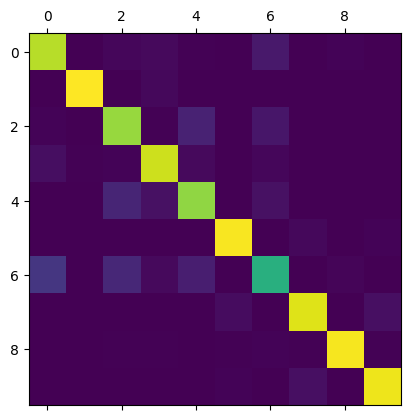

In [11]:
evaluate_model(model, test_dataloader, num_test_iters, device)
#evaluate_model(model1, test_dataloader, num_test_iters, device)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>